## According to the tutorial in:
https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

In [54]:
import numpy as np
import pandas as pd
import pydicom
import os
from glob import glob
import matplotlib.pyplot as plt

## Data Loading

In [55]:
data_path = "C:/Users/User/Dropbox/Agamon/siim/dicom_dir"
g = glob(data_path + '/*.dcm')

# Print out the first 5 file names to verify we're in the right folder.
print ("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
print ('\n'.join(g[:5]))

Total of 100 DICOM images.
First 5 filenames:
C:/Users/User/Dropbox/Agamon/siim/dicom_dir\ID_0000_AGE_0060_CONTRAST_1_CT.dcm
C:/Users/User/Dropbox/Agamon/siim/dicom_dir\ID_0001_AGE_0069_CONTRAST_1_CT.dcm
C:/Users/User/Dropbox/Agamon/siim/dicom_dir\ID_0002_AGE_0074_CONTRAST_1_CT.dcm
C:/Users/User/Dropbox/Agamon/siim/dicom_dir\ID_0003_AGE_0075_CONTRAST_1_CT.dcm
C:/Users/User/Dropbox/Agamon/siim/dicom_dir\ID_0004_AGE_0056_CONTRAST_1_CT.dcm


## Loading all dicoms and images into lists

In [56]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

## Example - the first dicom file (contains a lot of meta data)

In [57]:
patient[0]

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20000621'
(0008, 0013) Instance Creation Time              TM: '163834'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6450.9002.588397851877365139904454952804
(0008, 0020) Study Date                          DA: '20000621'
(0008, 0021) Series Date                         DA: '20000621'
(0008, 0022) Acquisition Date                    DA: '20000621'
(0008, 0023) Content Date                        DA: '20000621'
(0008, 0030) Study Time                          TM: '163602'
(0008, 0031) Series Time                         TM: '163730'
(0008, 0032) Acquisition Time                    TM: '163826'
(0008, 0033) Content Time                        TM: '163834'
(0008, 0050) Accession Number 

## example - the first patient's pixel array (in HU)

In [58]:
patient[0].pixel_array

array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       ...,
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024]], dtype=int16)

## example - the first patient's pixel array plotted

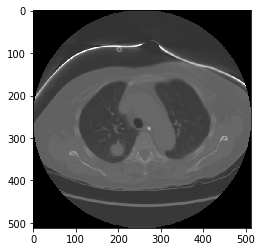

In [59]:
plt.imshow(patient[0].pixel_array,cmap='gray')